In [1]:
import torch
import numpy as np
from datasets import load_dataset

import tqdm
import multiprocessing as mp

import matplotlib.pyplot as plt

from crypto.utils import *

import torchvision.transforms as T

from phe import paillier

from crypto.modules.mlp import SimpleMLP
from torch.utils.data import DataLoader

/Users/alessandrozirilli/Progetti/crypto-playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SimpleMLP()

best_model_wts= torch.load("best_model.pth", map_location=torch.device('cpu'))

model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [3]:
public_key, private_key = paillier.generate_paillier_keypair()

In [4]:
ds = load_dataset("ylecun/mnist")

# Let's try to normalise encrypted data

In [5]:
transform = T.Compose([
    T.ToTensor(),
])


ds.set_transform(get_apply_transform(transform))

test_loader = DataLoader(
    ds["test"],
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
first = next(iter(test_loader))[0][0]

In [7]:
first.shape

torch.Size([1, 28, 28])

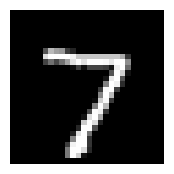

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.imshow(first.squeeze(), cmap='gray')
ax.axis('off')

plt.show()

In [9]:
image = encrypt_matrix_parallel(first.squeeze())

Using 28 CPUs


100%|██████████| 28/28 [03:34<00:00,  7.65s/it]  


In [10]:
mean = -0.1307
std = 1 / 0.3081

normalised_matrix = []

for row in image:
    encrypted_row = []
    for el in row:
        # Add scalar (mean) in encrypted space
        el = el + mean   # el = el + mean
        # Multiply by std in encrypted space
        el = el * std            # el = el * std
        encrypted_row.append(el)
    normalised_matrix.append(encrypted_row)

In [11]:
torch_norm = T.Normalize((0.1307,), (0.3081,))
first_tensor = first.clone() 
normalized_torch = torch_norm(first_tensor)

In [12]:
decrypted_matrix = []

for row in normalised_matrix:
    decrypted_row = []
    for el in row:
        decrypted_row.append(private_key.decrypt(el)) 
    decrypted_matrix.append(decrypted_row)

decrypted_tensor = torch.tensor(decrypted_matrix, dtype=first.dtype)

print("Max absolute difference:", torch.max(torch.abs(decrypted_tensor - normalized_torch)))
print("Mean absolute difference:", torch.mean(torch.abs(decrypted_tensor - normalized_torch)))

Max absolute difference: tensor(2.3842e-07)
Mean absolute difference: tensor(3.9907e-08)


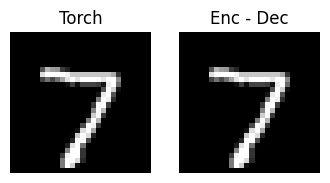

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(4, 8))

ax[0].set_title("Torch")
ax[0].imshow(normalized_torch.squeeze(), cmap='gray')
ax[0].axis('off')

ax[1].set_title("Enc - Dec")
ax[1].imshow(decrypted_tensor, cmap='gray')
ax[1].axis('off')

plt.show()

# Let's test inference on an encrypted number

In [5]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

ds.set_transform(get_apply_transform(transform))

test_loader = DataLoader(
    ds["test"],
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
data_iter = iter(test_loader)
batch_images, batch_labels = next(data_iter)

images = batch_images[:10]
labels = batch_labels[:10]

print(f"Loaded {len(images)} images for processing.")

Loaded 10 images for processing.


In [7]:
enc_images_list = []

for i in range(len(images)):
    img_tensor = images[i].squeeze()
    
    enc_image = encrypt_matrix_parallel(img_tensor, public_key)
    enc_images_list.append(enc_image)



100%|██████████| 28/28 [00:55<00:00,  1.98s/it]


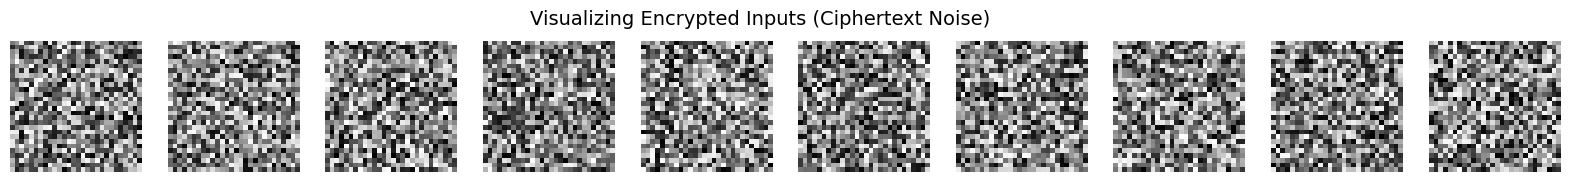

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
fig.suptitle("Visualizing Encrypted Inputs (Ciphertext Noise)", fontsize=14)

def plot_encrypted_matrix(enc_matrix, ax):

    cipher_matrix = [
        [num.ciphertext() for num in row] 
        for row in enc_matrix
    ]

    img_data = np.array(
        [[val % 255 for val in row] for row in cipher_matrix], 
        dtype=float
    )

    # 3. Plot
    ax.imshow(img_data, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')


for i in range(10):
    ax = axes[i]
    enc_matrix = enc_images_list[i]

    plot_encrypted_matrix(enc_matrix, ax)

plt.show()

In [13]:
from crypto.modules.pailler_mlp import PaillerMLP

preds = []

pailler_mlp = PaillerMLP(model)
for i, enc_image in enumerate(enc_images_list):
    flatten_image = []
    for row in enc_image:
        flatten_image.extend(row)
        
    with torch.no_grad():
        output_enc = pailler_mlp(flatten_image)

    decrypted_logits = [private_key.decrypt(x) for x in output_enc]
    
    predicted_class = decrypted_logits.index(max(decrypted_logits))
    preds.append(predicted_class)
    

Layer 1 Mul: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


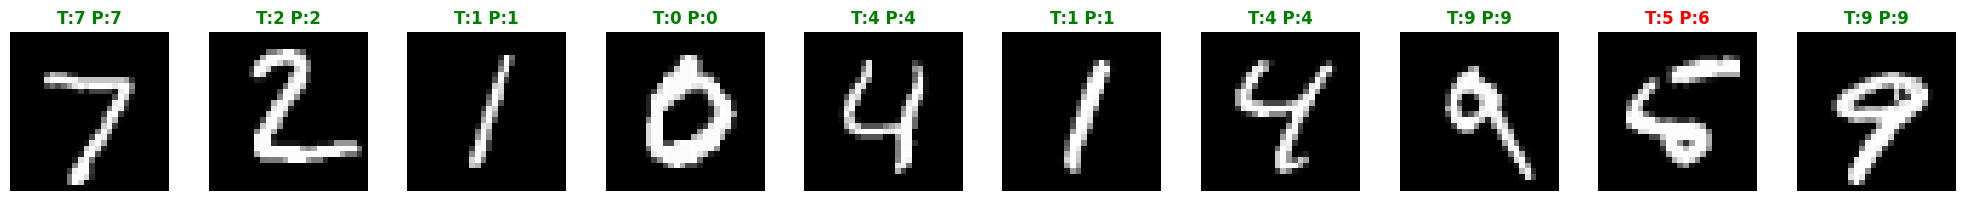

In [15]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    ax = axes[i]
    img = images[i].squeeze() 
    ax.imshow(img, cmap='gray')

    is_correct = labels[i] == preds[i]
    title_color = 'green' if is_correct else 'red'
    
    ax.set_title(f"T:{labels[i]} P:{preds[i]}", color=title_color, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()